# BrkRaw Tutorial 2: Orientation, Unwrap Pose vs Subject Pose

This notebook shows why preclinical datasets can look wrong when a scanner assumes a human-pose coordinate system. We compare three affines for the same data matrix: the system pose, a scanner-view unwrap, and a true subject-pose override. We then reorient to RAS for visualization.

## 1. Load the example dataset

This notebook assumes `data/brkraw-dataset` is already available. If not, run the download step in `00_getting_started.ipynb`.

In [1]:
from pathlib import Path
import brkraw as brk

DATASET_REPO = Path("data") / "brkraw-dataset"
if not DATASET_REPO.exists():
    raise FileNotFoundError("Dataset repo not found. Run the download step first.")

dataset_zip = DATASET_REPO / "PV5.1" / "UNC_PV5.1_BOLD-EPI_TurboRARE.zip"
loader = brk.load(str(dataset_zip))
loader.avail

{3: Scan(id=3 rel='/3' Method='FLASH'),
 4: Scan(id=4 rel='/4' Method='FieldMap'),
 9: Scan(id=9 rel='/9' Method='RARE'),
 11: Scan(id=11 rel='/11' Method='EPI')}

## 2. Helper: reorient to RAS

We use a simple nibabel-based helper to reorient arrays to RAS so the plots are consistent across affines.

In [2]:
import numpy as np
import nibabel as nib

def reorient_to_ras(data, affine):
    ornt = nib.orientations.io_orientation(affine)
    ras_ornt = np.array([[0, 1], [1, 1], [2, 1]])  # RAS
    transform = nib.orientations.ornt_transform(ornt, ras_ornt)
    new_data = nib.orientations.apply_orientation(data, transform)
    new_affine = affine @ nib.orientations.inv_ornt_aff(transform, data.shape)
    return new_data, new_affine

## 3. Fetch data and affines

We load a single data matrix once, then compare four different affines: (1) Paravision default, (2) the system-configured subject pose in RAS, (3) a scanner-view unwrap, and (4) an override that reflects the actual animal pose.

This dataset was labeled as Head_Supine even though it was acquired in a Head_Prone setup. In older Paravision versions there was no animal-specific pose, so `Head_Supine` was commonly used because it made the viewport orientation look correct. From PV360 onward, Paravision provides a dedicated preclinical view, removing this workaround and the resulting mismatch. For rodents, the subject type is `Quadruped`, so we override both the subject type and pose to match the true acquisition.

The core idea is to standardize on a scanner-view coordinate system first: X increases left-to-right from the operator view, Y increases bottom-to-top, and Z increases front-to-back along the bore. This removes ambiguity from legacy human-pose settings. From that stable scanner view, applying the true subject type and pose recovers the intended subject coordinate system.


Note: For multiple slice-pack images (e.g., localizers), the get methods return a tuple. For this tutorial, `first_pack` simply selects the first entry so we can work with a single image and its affine.

In [3]:
def first_pack(value):
    return value[0] if isinstance(value, tuple) else value

scan_id = 9
reco_id = 1

data = first_pack(loader.get_dataobj(scan_id, reco_id=reco_id))

affine_original = first_pack(
    loader.get_affine(scan_id, reco_id=reco_id, space='raw')
)
affine_subjras = first_pack(
    loader.get_affine(scan_id, reco_id=reco_id, space='subject_ras')
)
affine_unwrapped = first_pack(
    loader.get_affine(scan_id, reco_id=reco_id, space='scanner')
)
affine_override = first_pack(
    loader.get_affine(scan_id, reco_id=reco_id, space='subject_ras',
                      override_subject_type="Quadruped",
                      override_subject_pose="Head_Prone")
)

## 4. Reorient to RAS and visualize

We reorient each (data, affine) pair to RAS and compare a mid-slice to make the orientation differences explicit.

Terminology notes:
- **Unwrap pose** means the scanner view (X right, Y up, Z back in operator‑facing axes). The text labels describe the axis directions in each world space.
- **Subject pose applied** means BrkRaw wraps the scanner view back to a subject base orientation using the reported subject type and pose. The printed `axcodes` describe the subject’s actual orientation axes after this mapping.

In this dataset, the recorded pose implies LPS (Head_Supine), but the animal was actually Head_Prone (RIA). Applying the recorded pose can therefore flip axes and obscure the true orientation, so we inspect both views before trusting the reported orientation.

In [4]:
data_original_ras, affine_original_ras = reorient_to_ras(data, affine_original)
data_subject_ras, affine_subject_ras = reorient_to_ras(data, affine_subjras)
data_unwrapped_ras, affine_unwrapped_ras = reorient_to_ras(data, affine_unwrapped)
data_override_ras, affine_override_ras = reorient_to_ras(data, affine_override)

## 4b. Orthogonal views

Now that the dataobj orientation has been corrected and the affine applied, we use the resulting world coordinates (x, y, z) to define [x, y], [x, z], and [y, z] planes. The orthogonal viewer below uses voxel size with the scanner bore center as the zero point and a lower-left origin.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def _apply_affine(aff, ijk):
    ijk = np.asarray(ijk, dtype=float)
    ijk1 = np.c_[ijk, np.ones(len(ijk))]
    xyz = ijk1 @ aff.T
    return xyz[:, :3]

def _extent_for_plane(shape, affine, plane, fixed_index):
    nx, ny, nz = shape
    if plane == "axial":  # x-y at k
        corners = [(0, 0, fixed_index),
                   (nx - 1, 0, fixed_index),
                   (0, ny - 1, fixed_index),
                   (nx - 1, ny - 1, fixed_index)]
        world = _apply_affine(affine, corners)
        xs, ys = world[:, 0], world[:, 1]
        return [xs.min(), xs.max(), ys.min(), ys.max()]
    if plane == "coronal":  # x-z at j
        corners = [(0, fixed_index, 0),
                   (nx - 1, fixed_index, 0),
                   (0, fixed_index, nz - 1),
                   (nx - 1, fixed_index, nz - 1)]
        world = _apply_affine(affine, corners)
        xs, zs = world[:, 0], world[:, 2]
        return [xs.min(), xs.max(), zs.min(), zs.max()]
    if plane == "sagittal":  # y-z at i
        corners = [(fixed_index, 0, 0),
                   (fixed_index, ny - 1, 0),
                   (fixed_index, 0, nz - 1),
                   (fixed_index, ny - 1, nz - 1)]
        world = _apply_affine(affine, corners)
        ys, zs = world[:, 1], world[:, 2]
        return [ys.min(), ys.max(), zs.min(), zs.max()]
    raise ValueError("plane must be axial/coronal/sagittal")

def plot_orthogonal_world(dataobj, affine, title):
    nx, ny, nz = dataobj.shape
    i, j, k = nx // 2, ny // 2, nz // 2

    views = [
        ("Axial (x, y)", dataobj[:, :, k].T, _extent_for_plane(dataobj.shape, affine, "axial", k)),
        ("Coronal (x, z)", dataobj[:, j, :].T, _extent_for_plane(dataobj.shape, affine, "coronal", j)),
        ("Sagittal (y, z)", dataobj[i, :, :].T, _extent_for_plane(dataobj.shape, affine, "sagittal", i)),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=70)
    for ax, (label, img, extent) in zip(axes, views):
        ax.imshow(img, cmap="gray", origin="lower", extent=extent)
        ax.set_title(label)
        ax.set_aspect("equal")
        ax.axis("off")

    fig.suptitle(title)
    plt.tight_layout()

You can inspect the plots by running the command below. The text labels describe the axis directions in each world space, while the printed axcodes describe the subject's actual orientation axes.


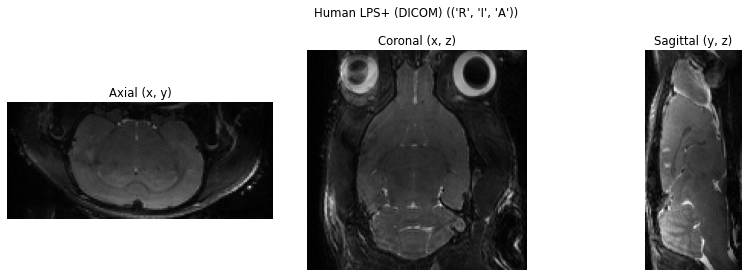

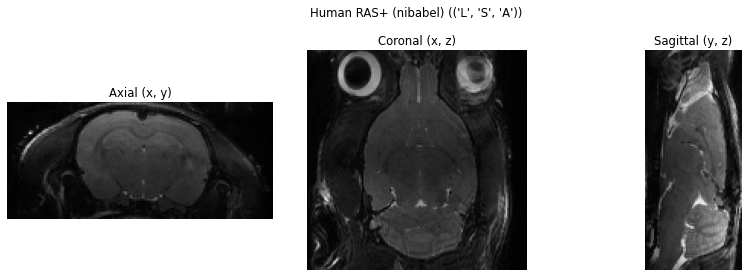

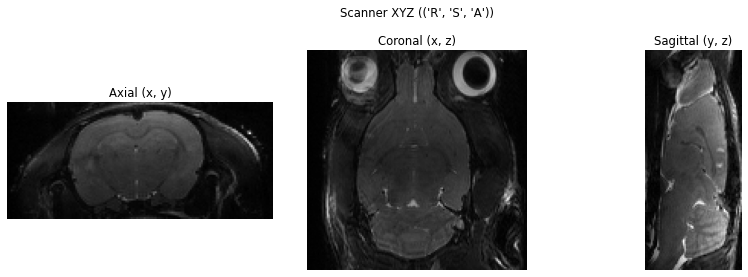

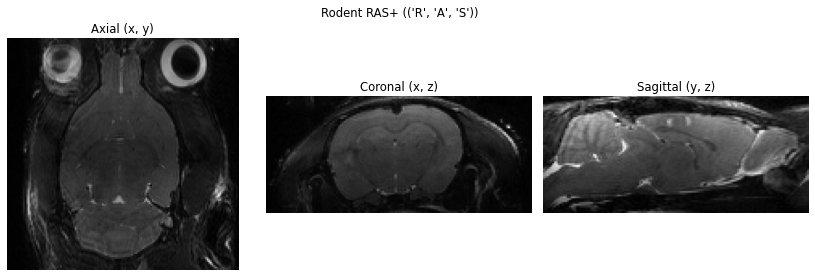

In [6]:
axcodes_original = nib.orientations.aff2axcodes(affine_original, labels=(('L', 'R'), ('A','P'), ('I', 'S')))
axcodes_subjras = nib.orientations.aff2axcodes(affine_subjras, labels=(('L', 'R'), ('P','A'), ('S', 'I')))
axcodes_unwrapped = nib.orientations.aff2axcodes(affine_unwrapped, labels=(('L', 'R'), ('P','A'), ('S', 'I')))
axcodes_override = nib.orientations.aff2axcodes(affine_override, labels=(('L', 'R'), ('A','P'), ('I', 'S')))

plot_orthogonal_world(data_original_ras, affine_original_ras, f"Human LPS+ (DICOM) ({axcodes_original})")
plot_orthogonal_world(data_subject_ras, affine_subject_ras, f"Human RAS+ (nibabel) ({axcodes_subjras})")
plot_orthogonal_world(data_unwrapped_ras, affine_unwrapped_ras, f"Scanner XYZ ({axcodes_unwrapped})")
plot_orthogonal_world(data_override_ras, affine_override_ras, f"Rodent RAS+ ({axcodes_override})")